In [1]:
# Import necessary libraries
import h5py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm

import torch
from torch.utils.data import Dataset
import h5py

In [2]:
import h5py
import numpy as np
from tqdm import tqdm
import random

# Define nucleotide to integer mapping, including 'N' for unknown nucleotides
nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
unknown_nucleotide_index = 4  # Index for unknown nucleotides
vocab_size = 5  # 4 nucleotides + 1 unknown ('N')

input_file = '/mnt/f/hprc/hprc-v1.1-mc-chm13_segments.gfa'
output_file = '/mnt/f/hprc/segments_b.hdf5'

# Splitting probabilities
train_prob = 0.8
val_prob = 0.1
test_prob = 0.1

assert train_prob + val_prob + test_prob == 1.0, "Split probabilities must sum to 1.0"

# Initialize counts
train_count = 0
val_count = 0
test_count = 0

max_seq_to_read = 10000
seq_read = 0
# Open HDF5 file and create datasets
with h5py.File(output_file, 'w') as hdf5_file:
    dt = h5py.vlen_dtype(np.uint8)
    train_dataset = hdf5_file.create_dataset('train_sequences', shape=(0,), maxshape=(None,), dtype=dt)
    val_dataset = hdf5_file.create_dataset('val_sequences', shape=(0,), maxshape=(None,), dtype=dt)
    test_dataset = hdf5_file.create_dataset('test_sequences', shape=(0,), maxshape=(None,), dtype=dt)
    
    # Open input file and read sequences
    with open(input_file, 'r') as f:
        for line in tqdm(f, desc="Processing sequences"):
            seq = line.strip().split("\t")[2]
            if not seq:
                continue  # Skip empty lines
            
            # Encode sequence to integers, mapping unknown nucleotides to unknown_nucleotide_index
            encoded_seq = np.array(
                [nucleotide_to_index.get(nuc.upper(), unknown_nucleotide_index) for nuc in seq],
                dtype=np.uint8
            )
            if len(encoded_seq) == 0:
                continue  # Skip if sequence is empty after encoding
            
            # Randomly assign sequence to train, val, or test set
            rand_num = random.random()
            if rand_num < train_prob:
                dataset = train_dataset
                train_count += 1
            elif rand_num < train_prob + val_prob:
                dataset = val_dataset
                val_count += 1
            else:
                dataset = test_dataset
                test_count += 1
            
            # Resize dataset and store sequence
            dataset.resize((dataset.shape[0] + 1,))
            dataset[-1] = encoded_seq

            seq_read += 1
            if seq_read == max_seq_to_read:
                break

print(f"Finished processing. Train sequences: {train_count}, Validation sequences: {val_count}, Test sequences: {test_count}")


Processing sequences: 9999it [00:00, 28802.41it/s]

Finished processing. Train sequences: 8084, Validation sequences: 954, Test sequences: 962


In [3]:
import torch
from torch.utils.data import Dataset
import h5py

class DNADataset(Dataset):
    def __init__(self, hdf5_file_path, split='train', chunk_size=512, overlap=0, mask_prob=0.15):
        self.hdf5_file_path = hdf5_file_path
        self.split = split  # 'train', 'val', 'test'
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.mask_prob = mask_prob
        self.vocab_size = 7  # 4 nucleotides + 1 unknown ('N') + 1 [MASK] token + 1 padding index

        self.padding_index = self.vocab_size - 1  # Padding index
        self.mask_token_index = self.vocab_size - 2  # [MASK] token index

        self.hdf5_file = h5py.File(self.hdf5_file_path, 'r')
        self.sequences = self.hdf5_file[f'{self.split}_sequences']
        self.chunks = self._create_chunks()

    def _create_chunks(self):
        chunks = []
        for idx, seq in enumerate(self.sequences):
            seq_len = len(seq)
            if seq_len == 0:
                continue  # Skip empty sequences
            if seq_len <= self.chunk_size:
                chunks.append((idx, 0, seq_len))
            else:
                step = self.chunk_size - self.overlap
                for start in range(0, seq_len - self.chunk_size + 1, step):
                    end = start + self.chunk_size
                    chunks.append((idx, start, end))
                # Handle the last chunk if it doesn't fit exactly
                if (seq_len - self.chunk_size) % step != 0:
                    start = seq_len - self.chunk_size
                    end = seq_len
                    chunks.append((idx, start, end))
        return chunks

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        seq_idx, start, end = self.chunks[idx]
        seq = self.sequences[seq_idx][start:end]
        seq_tensor = torch.from_numpy(seq).long()  # Shape: (seq_len,)

        # Apply masking for MLM
        input_seq, labels = self._apply_masking(seq_tensor)

        return input_seq, labels

    def _apply_masking(self, seq_tensor):
        seq_len = seq_tensor.size(0)
        labels = seq_tensor.clone()  # Original labels

        # Create mask for MLM
        mask = torch.rand(seq_len) < self.mask_prob  # Decide which positions to mask
        labels[~mask] = -100  # We only compute loss on masked positions

        # Replace masked positions with [MASK] token index
        input_seq = seq_tensor.clone()
        input_seq[mask] = self.mask_token_index  # [MASK] token index

        return input_seq, labels

    def __del__(self):
        self.hdf5_file.close()


In [4]:
def collate_fn(batch):
    inputs = [item[0] for item in batch]  # Each item[0] is a tensor of shape (seq_len,)
    labels = [item[1] for item in batch]  # Each item[1] is a tensor of shape (seq_len,)

    seq_lengths = [input_seq.size(0) for input_seq in inputs]
    max_length = max(seq_lengths)
    batch_size = len(inputs)

    # Assuming padding_index is vocab_size - 1
    padding_index = inputs[0].max().item() + 1  # Ensure padding index is unique
    for seq in inputs:
        padding_index = max(padding_index, seq.max().item() + 1)

    # Initialize tensors for inputs and labels
    padded_inputs = torch.full((batch_size, max_length), fill_value=padding_index, dtype=torch.long)
    padded_labels = torch.full((batch_size, max_length), fill_value=-100, dtype=torch.long)

    for i in range(batch_size):
        seq_len = inputs[i].size(0)
        padded_inputs[i, :seq_len] = inputs[i]
        padded_labels[i, :seq_len] = labels[i]

    return padded_inputs, padded_labels, padding_index


In [5]:
import torch.nn as nn
import numpy as np

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, dim_feedforward, dropout=0.1, padding_idx=None):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=padding_idx)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size - 1)  # Exclude padding index
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_key_padding_mask=None):
        # src: (batch_size, seq_len)
        x = self.embedding(src)  # Shape: (batch_size, seq_len, d_model)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # Transformer expects input as (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = x.transpose(0, 1)  # Back to (batch_size, seq_len, d_model)
        output = self.output_layer(x)  # Shape: (batch_size, seq_len, vocab_size - 1)
        return output


In [6]:
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create datasets
train_dataset = DNADataset(hdf5_file_path=output_file, split='train', chunk_size=512, overlap=0)
val_dataset = DNADataset(hdf5_file_path=output_file, split='val', chunk_size=512, overlap=0)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)


# Model parameters
vocab_size = train_dataset.vocab_size  # 4 nucleotides + 1 unknown + 1 [MASK] token + 1 padding index
d_model = 128
num_heads = 8
num_layers = 4
dim_feedforward = 512
dropout = 0.1
learning_rate = 1e-4

# Initialize model, criterion, and optimizer
model = TransformerModel(vocab_size=vocab_size, d_model=d_model, num_heads=num_heads,
                         num_layers=num_layers, dim_feedforward=dim_feedforward, dropout=dropout,
                         padding_idx=train_dataset.padding_index)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch_inputs, batch_labels, padding_index = batch
        batch_inputs = batch_inputs.to(device)  # Shape: (batch_size, seq_len)
        batch_labels = batch_labels.to(device)  # Shape: (batch_size, seq_len)

        optimizer.zero_grad()

        # Create src_key_padding_mask: True for padding positions
        src_key_padding_mask = (batch_inputs == padding_index)  # Shape: (batch_size, seq_len)

        outputs = model(batch_inputs, src_key_padding_mask=src_key_padding_mask)  # Shape: (batch_size, seq_len, vocab_size - 1)

        # Shift labels to exclude padding index
        adjusted_labels = batch_labels.clone()
        adjusted_labels[adjusted_labels == padding_index] = -100  # Ignore padding in loss computation
        adjusted_labels[adjusted_labels == model.embedding.padding_idx] = -100  # Ignore padding index in labels

        # Ensure labels are in the range [0, vocab_size - 2]
        adjusted_labels[adjusted_labels >= vocab_size - 1] = unknown_nucleotide_index

        loss = criterion(outputs.view(-1, vocab_size - 1), adjusted_labels.view(-1))

        if not torch.isfinite(loss):
            print("Loss is NaN or Inf, skipping batch")
            continue

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch_inputs, batch_labels, padding_index = batch
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            src_key_padding_mask = (batch_inputs == padding_index)

            outputs = model(batch_inputs, src_key_padding_mask=src_key_padding_mask)

            adjusted_labels = batch_labels.clone()
            adjusted_labels[adjusted_labels == padding_index] = -100
            adjusted_labels[adjusted_labels == model.embedding.padding_idx] = -100
            adjusted_labels[adjusted_labels >= vocab_size - 1] = unknown_nucleotide_index

            loss = criterion(outputs.view(-1, vocab_size - 1), adjusted_labels.view(-1))

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


/home/hamed/hprc_graph_embedding/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Loss is NaN or Inf, skipping batch
Epoch 1/10, Train Loss: 1.3757, Validation Loss: 1.3643
Epoch 2/10, Train Loss: 1.3390, Validation Loss: 1.3374
Epoch 3/10, Train Loss: 1.3330, Validation Loss: 1.3351
Epoch 4/10, Train Loss: 1.3375, Validation Loss: 1.3388
Epoch 5/10, Train Loss: 1.3335, Validation Loss: 1.3506
Epoch 6/10, Train Loss: 1.3285, Validation Loss: 1.3108
Loss is NaN or Inf, skipping batch
Epoch 7/10, Train Loss: 1.3260, Validation Loss: 1.3477
Epoch 8/10, Train Loss: 1.3277, Validation Loss: 1.3464
Loss is NaN or Inf, skipping batch
Epoch 9/10, Train Loss: 1.3163, Validation Loss: 1.3452
Loss is NaN or Inf, skipping batch
Epoch 10/10, Train Loss: 1.3201, Validation Loss: 1.3635


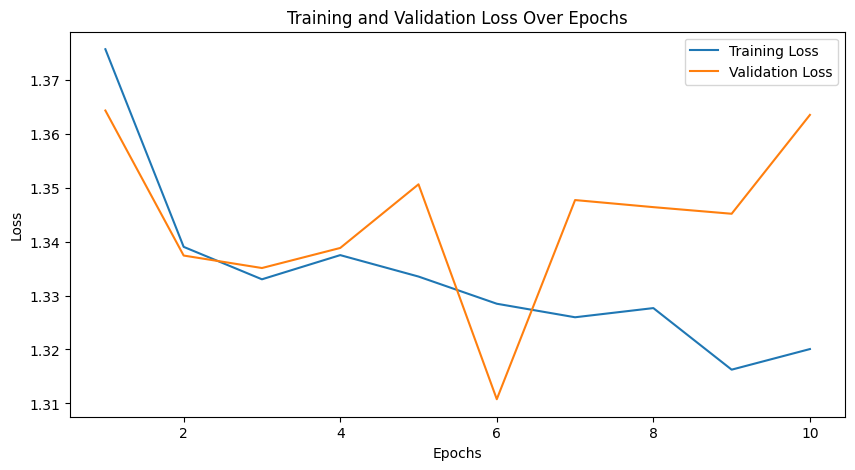

In [7]:
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()
